## Support Vector Machines

#### *25 October 2019*
#### *DATA 1010*

In [1]:
using Plots, Distributions, JuMP, Ipopt, Random
gr(fontfamily = "Palatino", size = (400,400), aspect_ratio = 1, legend = false); 

Consider a binary classification problem like this one:

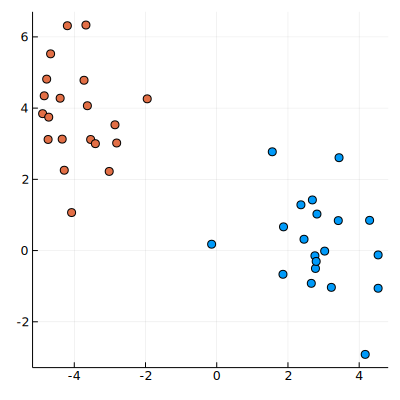

In [2]:
n = 20
Random.seed!(123)
X = [randn(n) .- 4 randn(n) .+ 4
     randn(n) .+ 3 randn(n)]
y = repeat([1,-1], inner = n)
function original_scatter()
    scatter(X[:, 1], X[:, 2], group = y)
end
original_scatter()

Setting aside probabilistic considerations, your visual cortex has an excellent idea for what to do: draw a line that separates the clusters as much as possible. Something like this:

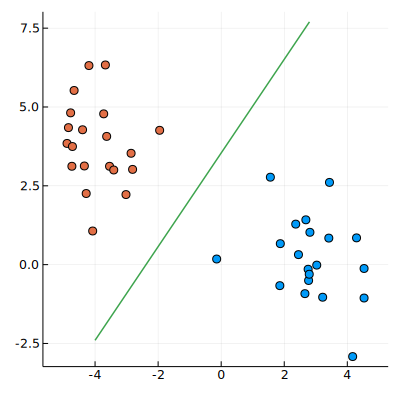

In [4]:
(a,b), (c,d) = (-4.0,-2.4), (2.8,7.7)
function add_line!()
    plot!([(a,b),(c,d)], linewidth = 1.5)
end
original_scatter()
add_line!()

This is the principle on which **support vector machines** are based. We look for a hyperplane (the solution set of a single linear equation; in other words, a line in 2D, an ordinary plane in 3D, etc.) which separates the clusters as much as possible. 

To quantify the the "as much as possible" idea, we introduce the idea of a separating slab:

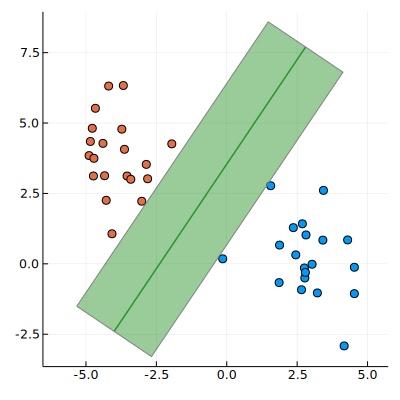

In [6]:
function slab(a,b,c,d,w)
    v = [b-d, c-a]
    v *= w/norm(v)
    Tuple.([[a,b] + v, [c,d] + v, [c,d] - v, [a,b] - v, [a,b] + v])
end
function add_slab!()
    plot!(slab(a,b,c,d,1.6), fillopacity = 0.4, seriestype = :shape, fillcolor = :green, linecolor = :gray)
end
original_scatter()
add_line!()
add_slab!()

(Note: we're defining the term *slab* mathematically here to mean the region between two parallel hyperplanes.)

We will look for the thickest separating slab and choose the hyperplane halfway between its boundaries as the decision surface. Note that the thickest separating slab necessarily has points on both boundaries; these points are called **support vectors**. 

---

This interactive graphic illustrates how we can describe a slab using a linear inequality of the form $-1 \leq \boldsymbol{\beta}'\mathbf{x} + \alpha \leq 1$. The level sets of the function $\boldsymbol{\beta}'\mathbf{x} + \alpha$ are hyperplanes which perpendicular to $\boldsymbol{\beta}$, and the spacing between consecutive integer level sets is $1/|\boldsymbol{\beta}|$, since the gradient of the function is $|\boldsymbol{\beta}|$. Therefore, we can adjust the norm of $\boldsymbol{\beta}$ to change the spacing, we can adjust $\boldsymbol{\beta}$ to change the angle, and we can adjust $\alpha$ to change the positioning.

In [8]:
using Interact
@manipulate for β₁ in -2:0.1:3, β₂ in -2:0.1:3, α in -2:0.1:2
    contour(-3:0.1:3, -5:0.1:5, (x,y) -> [β₁, β₂]' * [x,y] + α, size = (300,300),
            levels = -20:20, xlims = (-2,2), ylims = (-2,2), titlefont = font(10), 
            title = "level lines of $β₁ x + $β₂ y + $α")
end

Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[Scope(Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[Node{WebIO.DOM}(WebIO.DOM(:html, :label), Any["β₁"], Dict{Symbol,Any}(:className => "interact ",:style => Dict{Any,Any}(:padding => "5px 10px 0px 10px")))], Dict{Symbol,Any}(:className => "interact-flex-row-left")), Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[Node{WebIO.DOM}(WebIO.DOM(:html, :input), Any[], Dict{Symbol,Any}(:max => 51,:min => 1,:attributes => Dict{Any,Any}(:type => "range",Symbol("data-bind") => "numericValue: index, valueUpdate: 'input', event: {change: function (){this.changes(this.changes()+1)}}","orient" => "horizontal"),:step => 1,:className => "slider slider is-fullwidth",:style => Dict{Any,Any}()))], Dict{Symbol,Any}(:className => "interact-flex-row-center")), Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[Node{WebIO.DOM}(WebIO.DOM(:html, :p), Any[], Dict{Symbol,Any}(:attributes => Dict("data-bind" => "text: formatted_val")))], Dict{Symbol,Any}(:className => "interact-flex-row-right"))], Dict{Symbol,Any}(:className => "interact-flex-row interact-widget")), Dict{String,Tuple{Observables.AbstractObservable,Union{Nothing, Bool}}}("changes" => (Observable{Int64} with 1 listeners. Value:
0, nothing),"index" => (Observable{Any} with 2 listeners. Value:
26, nothing)), Set(String[]), nothing, Asset[Asset("js", "knockout", "/Users/sswatson/.julia/packages/Knockout/1sDlc/src/../assets/knockout.js"), Asset("js", "knockout_punches", "/Users/sswatson/.julia/packages/Knockout/1sDlc/src/../assets/knockout_punches.js"), Asset("js", nothing, "/Users/sswatson/.julia/packages/InteractBase/9mFwe/src/../assets/all.js"), Asset("css", nothing, "/Users/sswatson/.julia/packages/InteractBase/9mFwe/src/../assets/style.css"), Asset("css", nothing, "/Users/sswatson/.julia/packages/Interact/SbgIk/src/../assets/bulma_confined.min.css")], Dict{Any,Any}("changes" => Any[WebIO.JSString("(function (val){return (val!=this.model[\"changes\"]()) ? (this.valueFromJulia[\"changes\"]=true, this.model[\"changes\"](val)) : undefined})")],"index" => Any[WebIO.JSString("(function (val){return (val!=this.model[\"index\"]()) ? (this.valueFromJulia[\"index\"]=true, this.model[\"index\"](val)) : undefined})")]), WebIO.ConnectionPool(Channel{Any}(sz_max:32,sz_curr:0), Set(AbstractConnection[]), Base.GenericCondition{Base.AlwaysLockedST}(Base.InvasiveLinkedList{Task}(Task (runnable) @0x00000001357a3850, Task (runnable) @0x00000001357a3850), Base.AlwaysLockedST(1))), WebIO.JSString[WebIO.JSString("function () {\n    var handler = (function (ko, koPunches) {\n    ko.punches.enableAll();\n    ko.bindingHandlers.numericValue = {\n        init: function(element, valueAccessor, allBindings, data, context) {\n            var stringified = ko.observable(ko.unwrap(valueAccessor()));\n            stringified.subscribe(function(value) {\n                var val = parseFloat(value);\n                if (!isNaN(val)) {\n                    valueAccessor()(val);\n                }\n            });\n            valueAccessor().subscribe(function(value) {\n                var str = JSON.stringify(value);\n                if ((str == \"0\") && ([\"-0\", \"-0.\"].indexOf(stringified()) >= 0))\n                     return;\n                 if ([\"null\", \"\"].indexOf(str) >= 0)\n                     return;\n                stringified(str);\n            });\n            ko.applyBindingsToNode(\n                element,\n                {\n                    value: stringified,\n                    valueUpdate: allBindings.get('valueUpdate'),\n                },\n                context,\n            );\n        }\n    };\n    var json_data = {\"formatted_vals\":[\"-2.0\",\"-1.9\",\"-1.8\",\"-1.7\",\"-1.6\",\"-1.5\",\"-1.4\",\"-1.3\",\"-1.2\",\"-1.1\",\"-1.0\",\"-0.9\",\"-0.8\",\"-0.7\",\"-0.6\",\"-0.5\",\"-0.4\",\"-0.3\",\"-0.2\",\"-0.1\",\"0.0\",\"0.1\",\"0.2\",\"0.3\",\"0.4\",\"0.5\",\"0.6\

---

## Problem 1

Use JuMP to find the thickest separating slab for the data shown above. Compare the result to the slab plotted above, which was obtained by eyeballing it. (Note: to compare, you can just call `add_slab!()` after you make your own plot below). 

*Solution*. 

In [10]:
mutable struct SVM
    X # training features
    y # training labels
    α
    β
    C # we'll use this later
    η # this too
end

SVM(X,y) = SVM(X,y,0,0,1,0)

SVM

In [12]:
function fit!(S::SVM)
    m = Model(with_optimizer(Ipopt.Optimizer, print_level=0))
    
end

fit! (generic function with 2 methods)

In [14]:
S = SVM(X, y)
fit!(S)

A JuMP Model
Feasibility problem with:
Variables: 0
Model mode: AUTOMATIC
CachingOptimizer state: EMPTY_OPTIMIZER
Solver name: Ipopt

In [ ]:
import Plots.plot    
function plot(S::SVM)
    zone(t) = t > 1 ? 2 : (t > 0 ? 1 : (t > -1 ? -1 : -2))
    xmin, xmax = extrema(S.X[:,1])
    ymin, ymax = extrema(S.X[:,2])
    xmin -= (xmax - xmin)/20; xmax += (xmax - xmin)/20
    ymin -= (ymax - ymin)/20; ymax += (ymax - ymin)/20
    xgrid = range(xmin, xmax, length=512)
    ygrid = range(ymin, ymax, length=512)
    scatter(S.X[:,1], S.X[:,2], group = S.y, markersize = 2)
    contour!(xgrid, ygrid, (x,y) -> S.β'*[x,y] + S.α, 
              levels = [-1, 0, 1])
    heatmap!(xgrid, ygrid,
             (x,y) -> zone(S.β'*[x,y] + S.α), fillopacity = 0.5, 
             fillcolor = cgrad([:blue, :lightblue, :pink, :red]))
end

plot(S)

---

## Problem 2

The SVM described in Problem 1 is the *hard-margin* SVM; essentially we are paying an infinite price for every point which is either inside the slab or on the wrong side. A softer approach is to pay a *finite* price for that. Specifically, we will incur a penalty for each errant point which is proportional to the number of slab half-widths the point is from the correct side of the slab. This is called the *soft-margin* SVM. 

We can find the soft-margin SVM using JuMP as well. The minimization problem we want to solve is the following one: 

$$
\begin{array}{l}{\frac{1}{2}\|\boldsymbol{\beta}\|^{2}+C \mathbf{1}' \boldsymbol{\zeta}} \\ \text{subj. to }{\mathbf{y} \odot(X \boldsymbol{\beta}+\alpha \mathbf{1}) \succcurlyeq \mathbf{1}-\boldsymbol{\zeta} \text { and } \boldsymbol{\zeta} \succcurlyeq 0,}\end{array}
$$

where $\mathbf{1}$ denotes the vector of all ones (of whatever length makes sense), and where $\odot$ indicates elementwise multiplication. 

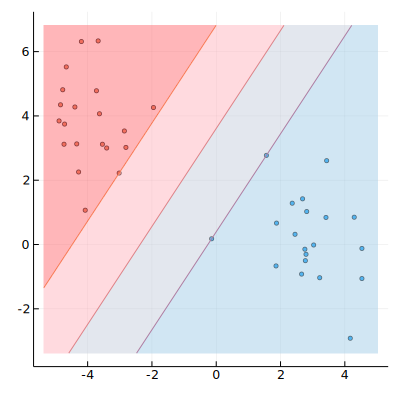

In [ ]:
S = SVM(X,y)
fit!(S, 1.0)
plot(S)

*Solution*. 

---

## Problem 3

The soft-margin SVM problem is equivalent to minimizing

$$
\frac{1}{2}\|\boldsymbol{\beta}\|^2 + C \mathbf{1}'\boldsymbol{\zeta} + H(\mathbf{1} - \boldsymbol{\zeta} -  \mathbf{y} \odot (X\boldsymbol{\beta} + \alpha\mathbf{1})) + H(-\boldsymbol{\zeta}). 
$$

where $H$ returns 0 for non-positive inputs and $\infty$ for positive inputs. This, in turn, is equivalent to 

$$
\min_{\alpha, \boldsymbol{\beta}, \boldsymbol{\zeta}} \max_{\boldsymbol{\eta}, \boldsymbol{\theta} \succcurlyeq \boldsymbol{0}}\left[\frac{1}{2}\|\boldsymbol{\beta}\|^2 + C \mathbf{1}'\boldsymbol{\zeta}  + \boldsymbol{\eta}'(\mathbf{1} - \boldsymbol{\zeta} -  \mathbf{y} \odot (X\boldsymbol{\beta} + \alpha\mathbf{1})) - \boldsymbol{\theta}'\zeta\right], 
$$

since $H(x) = \max_{\lambda \geq 0}( \lambda x)$. A result called Slater's Theorem tells us that in this case we can swap min and max, and that gives

$$
\begin{align*}
\max_{\boldsymbol{\eta}, \boldsymbol{\theta}\succcurlyeq \boldsymbol{0}}\min_{\alpha, \boldsymbol{\beta}, \boldsymbol{\zeta}} \Bigg[
&\frac{1}{2}\|\boldsymbol{\beta}\|^2 - \boldsymbol{\eta}' (\mathbf{y} \odot X\boldsymbol{\beta})
+ \boldsymbol{\eta}' \mathbf{1} + \\
&(C \mathbf{1}' - \boldsymbol{\eta}' - \boldsymbol{\theta}') \boldsymbol{\zeta} \\
&-\alpha\boldsymbol{\eta}'\mathbf{y}\Bigg]. 
\end{align*}
$$

(a) Differentiate the expression on the first line to find the minimizing value of $\boldsymbol{\beta}$.  

(b) What has to be true of $\boldsymbol{\eta}$ in order for the minimum in this expression to be anything other than $-\infty$?

(c) Use the code below to view the values of $\mathbf{\eta}$ for each training observation. Draw some conclusions based on what you see. 

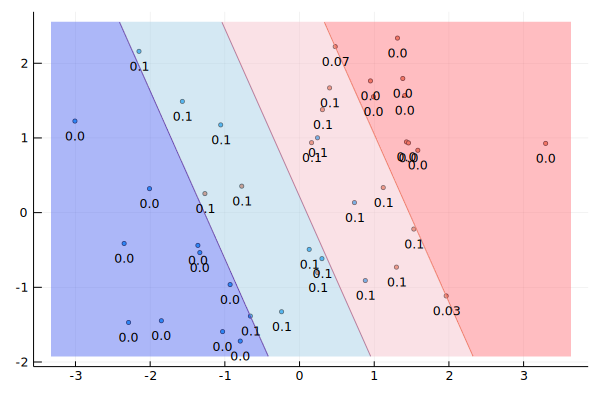

In [ ]:
function dualfit!(S::SVM, C)
    S.C = C
    nrows, ncols = size(S.X)
    model = Model(with_optimizer(Ipopt.Optimizer, print_level=0))
    @variable(model, η[1:nrows])
    @variable(model, α)
    @objective(model, Max, -1/2 * (η .* S.y)' * S.X * S.X' * (η .* S.y) + sum(η))
    @constraint(model, 0 .≤ η[1:nrows] .≤ S.C)
    @constraint(model, η' * S.y == 0)
    optimize!(model)
    S.η = value.(η)
    support_vectors = 1e-2 .<  S.η .< S.C - 1e-2
    S.β = S.X' * (S.η .* S.y)
    S.α = mean((S.y - X * S.β)[support_vectors])
    nothing
end

function plot(S::SVM, f::Function)
    P = plot(S)
    annotate!(P, [(S.X[i,1],S.X[i,2]-0.2,
                  text("$(abs(round(f(S,i),digits=2)))",8)) for i in 1:size(S.X,1)])
    plot!(P, size = (600,400))
    P
end

using Random; Random.seed!(1)
X = [randn(n) .+ 1 randn(n) .+ 1
     randn(n) .- 1 randn(n)]
y = repeat([1,-1], inner = n)
S = SVM(X, y)
dualfit!(S, 0.1)
plot(S, (S,i) -> S.η[i])

*Solution*.  
(a) Differentiating, setting the result equal to zero, and solving, we get $\beta = X'(\eta \odot y)$. 

(b) We have to have $\eta' y = 0$. In other words, the components of $\eta$ corresponding to +1 training observations have to sum to the same value as the components corresponding to -1 training observations. 

Note that that we also have to have $\eta + \theta = C$. In other words, every entry of $\eta$ has to be between 0 and $C$. 

(c) Looking at the figure, it seems that every safe point gets an $\eta$ value of 0, while every point on the wrong side of its edge of the slab gets an $eta$ value of $C$. The only points with $\eta$ values strictly between 0 and $C$ are the ones on their side of the slab, exactly on the edge. 

We can actually see why this is true by looking at the terms 
$$
\boldsymbol{\eta}'(\mathbf{1} - \boldsymbol{\zeta} -  \mathbf{y} \odot (X\boldsymbol{\beta} + \alpha\mathbf{1})) - \boldsymbol{\theta}'\zeta
$$
in the original optimization problem. If a particular component of $\mathbf{1} - \boldsymbol{\zeta} -  \mathbf{y} \odot (X\boldsymbol{\beta} + \alpha\mathbf{1})$ happens to be negative at a critical point (in other words, if the training point corresponding to that component is on the safe side of the slab), then the corresponding entry of $\boldsymbol{\eta}$ must be zero, since otherwise we could decrease it a little and lower the overall value of the objective function. 

Likewise, looking at the second term $-\boldsymbol{\theta}'\zeta$, we can see that if $\zeta_i$ is positive, that means that $\theta_i$ must be zero. Since $\eta_i + \theta_i = C$, this means that $\eta_i = C$. 

In [19]:
using MLDatasets
import LIBSVM

---

## Problem 4

Training support vector machines on large datasets requires special numerical methods to achieve reasonable performance. A lot of work has gone into doing this well, in the form of the library LIBSVM. LIBSVM has bindings for every major computing environment, including Julia. In this problem, we will use LIBSVM to determine whether there is a separating hyperplane between the zeros images and ones images in the MNIST training data.

The code below computes a soft-margin SVM a high $C$ value. Project every point in the dataset onto the vector $\beta$ and determine whether the zeros and ones are fully separated in that direction.

*Solution*. 

In [20]:
features, labels = MNIST.traindata()
features = reshape(features[:, :, labels .∈ Ref((0, 1))], (28^2, :))
labels = labels[labels .∈ Ref((0,1))];
#labels[labels .== 0] .= -1;
Gray.(reshape(1 .- features[:,1], (28, 28)))

In [22]:
model = LIBSVM.svmtrain(float(features), float(labels), kernel = LIBSVM.Kernel.Linear, cost = 100.0);

In [ ]:
# this is how to recover the value of β from the data stored in the model during training:
β = model.SVs.X * model.coefs